- https://youtu.be/Q_MbN-vu_2w?si=TrCYKV6q64rN6-Fq
- https://youtu.be/qBs29egdVNU?si=9X_UuFSqqsLBNndo
- https://youtu.be/cZ5w3b9ES7Q?si=NaiWh-SkPjqmKlmS

# [자전거 공유 수요](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
워싱턴D.C 소재의 자전거 대여 스타트업의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표!!

## 평가지표 - RMSLE
- Root Mean Squared Logarithmic Error
- 잔차(residual)에 대한 평균에 로그를 씌운 값
- 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
- 정답에 대한 오류를 숫자로 나타낸 값이 클 수록 오차가 크다는 의미이다.
  - 즉, 값이 작을 수록 오류가 적다는 의미를 나타낸다.

$$ RMSLE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1)-log(y\hat{}_{i}+1))^2}$$

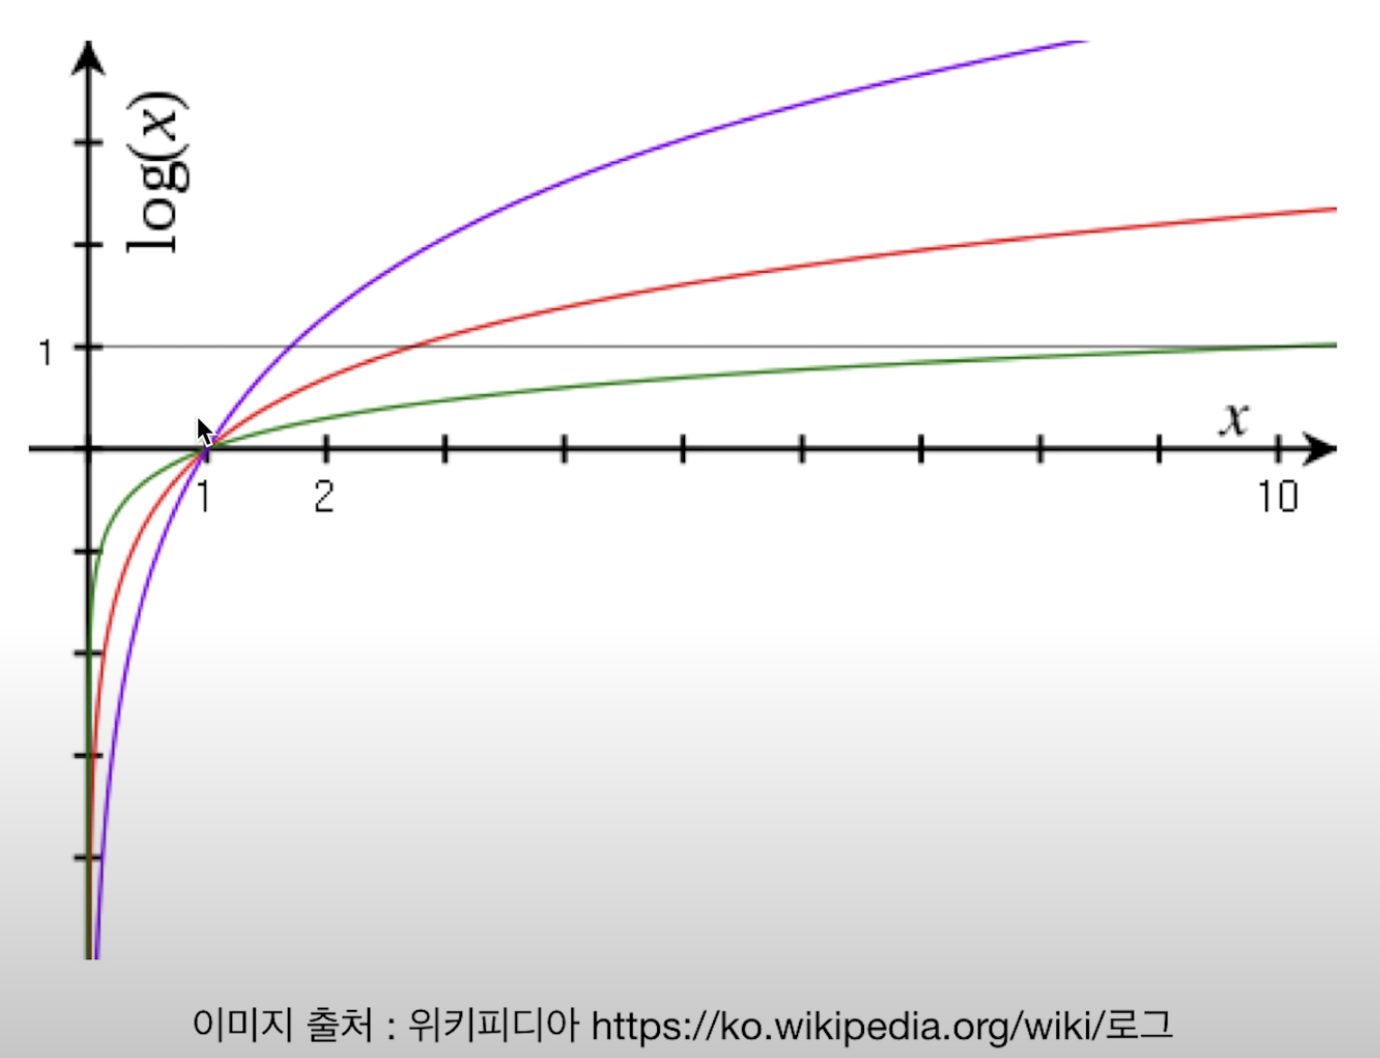

In [ ]:
import numpy as np

def rmsle(y, pred, convertExp=False):
    if convertExp:
        y = np.exp(y)
        pred = np.exp(pred)

    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in pred]))
    calc = (log1 - log2)**2

    return np.sqrt(np.mean(calc))

In [ ]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## [Data 설명](https://www.kaggle.com/competitions/bike-sharing-demand/data?select=sampleSubmission.csv)

### Features

- datetime:  
  - hourly date + timestamp  
- season(계절):  
  - 1 = spring
  - 2 = summer
  - 3 = fall
  - 4 = winter
- holiday(휴일):  
  - whether the day is considered a holiday
- workingday(근무일):
  - whether the day is neither a weekend nor holiday
- weather(날씨):
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp(온도):
  - temperature in Celsius
- atemp(체감온도):
  - "feels like" temperature in Celsius
- humidity(습도):
  - relative humidity
- windspeed(풍속):
  - wind speed

### Target

- count:
  - 총 대여 수
  - number of total rentals

참고용
- casual:
  - 미등록 사용자 대여 개시 수
  - number of non-registered user rentals initiated
- registered:
  - 등록 사용자 대여 개시
  -  number of registered user rentals initiated

# Import Library

In [ ]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')



# 데이터 분리
from sklearn.model_selection import train_test_split


# warning
import warnings
warnings.filterwarnings('ignore')

## Connect to google account

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# Global Variables

In [ ]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_ScalingModel_{0:.5f}.csv'

args.SEED = 42
args.target_col = 'count'

# Load Data

## train data

In [ ]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### target

In [ ]:
ori_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

## test data

In [ ]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)
ori_test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


## 결측치 확인

In [ ]:
ori_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
ori_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## 데이터 타입 확인

In [ ]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### 데이터 타입 변경

In [ ]:
ori_train['datetime'] = pd.to_datetime(ori_train['datetime'])
ori_test['datetime'] = pd.to_datetime(ori_test['datetime'])

In [ ]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 변수 생성

In [ ]:
print(f'before: {ori_train.shape} / {ori_test.shape}')

for data in [ori_train, ori_test]:
  data['year'] = data['datetime'].dt.year # 년도
  data['month'] = data['datetime'].dt.month # 월
  data['day'] = data['datetime'].dt.day # 일
  data['dayofweek'] = data['datetime'].dt.dayofweek # 요일
  data['quarter'] = data['datetime'].dt.quarter # 분기
  data['hour'] = data['datetime'].dt.hour # 시간
  data['minute'] = data['datetime'].dt.minute # 분
  data['second'] = data['datetime'].dt.second # 초

  data['weekend'] = data['dayofweek'].apply(lambda x: int(x in [5,6]))

print(f'after: {ori_train.shape} / {ori_test.shape}')

before: (10886, 12) / (6493, 9)
after: (10886, 21) / (6493, 18)


## 필요없는 컬럼 제거

- test에 없는 컬럼 제외

In [ ]:
drop_cols = list(set(ori_train.columns) - set(ori_test.columns))
drop_cols.remove('count') # target 제외
drop_cols

['casual', 'registered']

In [ ]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 21)
after: (10886, 19)


In [ ]:
drop_cols = ['minute', 'second']
ori_train[drop_cols].describe()

,minute,second
count,10886.0,10886.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [ ]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
ori_test = ori_test.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 19)
after: (10886, 17)


In [ ]:
ori_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,quarter,hour,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,1,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1,1,1


In [ ]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 17) / (6493, 16)


# Feature Engineering

In [ ]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 17) / (6493, 16)


In [ ]:
pre_train = ori_train.copy()
pre_test = ori_test.copy()

pre_train.shape, pre_test.shape

((10886, 17), (6493, 16))

## 다중공선성 처리

<Axes: >

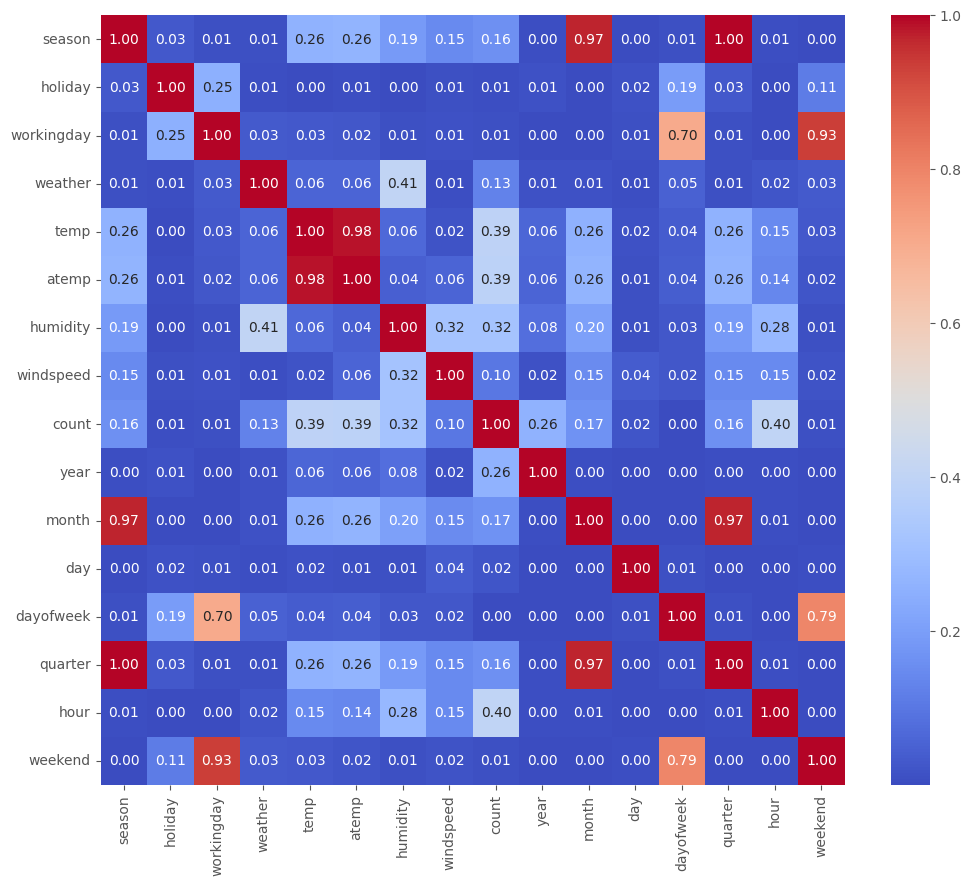

In [ ]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(pre_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_temp = pca.fit_transform(pre_train[['temp', 'atemp']])
pre_train = pre_train.drop(['temp', 'atemp'], axis=1)
pre_train['pca_temp'] = pca_temp

pca_temp = pca.transform(pre_test[['temp', 'atemp']])
pre_test = pre_test.drop(['temp', 'atemp'], axis=1)
pre_test['pca_temp'] = pca_temp

In [ ]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_month = pca.fit_transform(pre_train[['month', 'quarter', 'season']])
pre_train = pre_train.drop(['month', 'quarter', 'season'], axis=1)
pre_train['pca_month'] = pca_month

pca_month = pca.transform(pre_test[['month', 'quarter', 'season']])
pre_test = pre_test.drop(['month', 'quarter', 'season'], axis=1)
pre_test['pca_month'] = pca_month

In [ ]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_workingday = pca.fit_transform(pre_train[['workingday', 'dayofweek', 'weekend']])
pre_train = pre_train.drop(['workingday', 'dayofweek', 'weekend'], axis=1)
pre_train['pca_workingday'] = pca_workingday

pca_workingday = pca.transform(pre_test[['workingday', 'dayofweek', 'weekend']])
pre_test = pre_test.drop(['workingday', 'dayofweek', 'weekend'], axis=1)
pre_test['pca_workingday'] = pca_workingday

<Axes: >

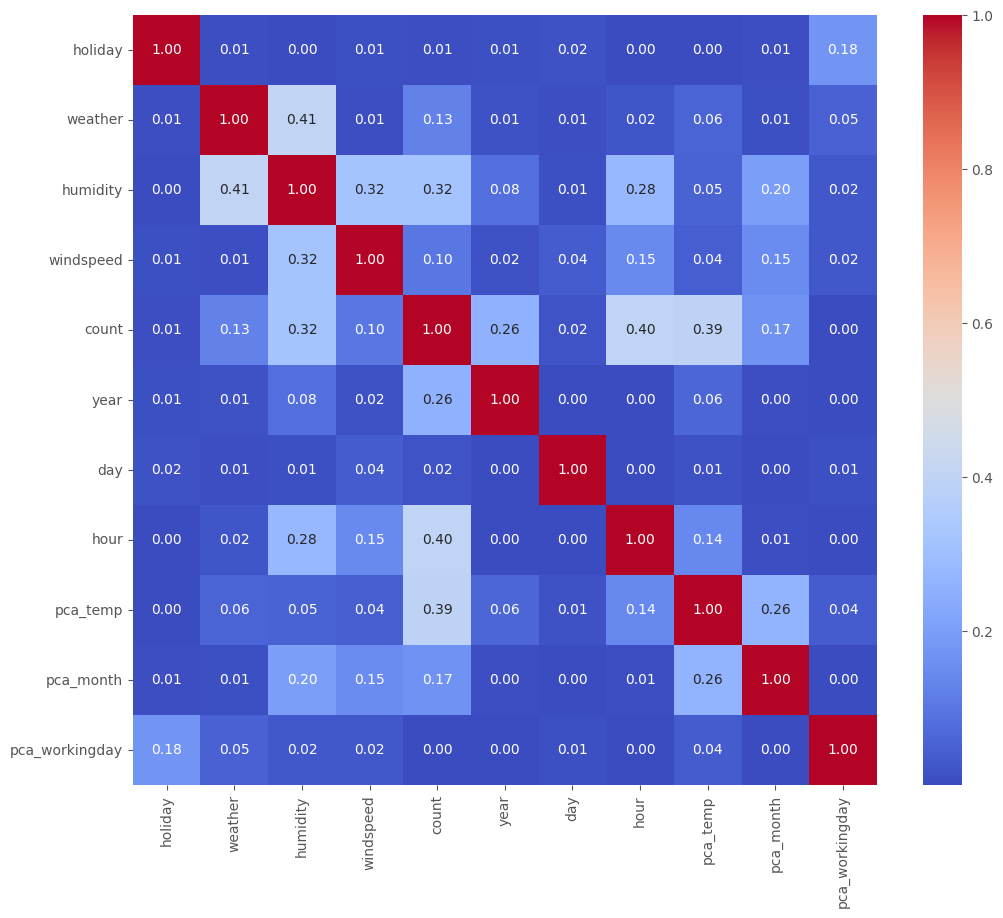

In [ ]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(pre_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

## windspeed
- windspeed의 0값 처리

<Axes: xlabel='windspeed', ylabel='count'>

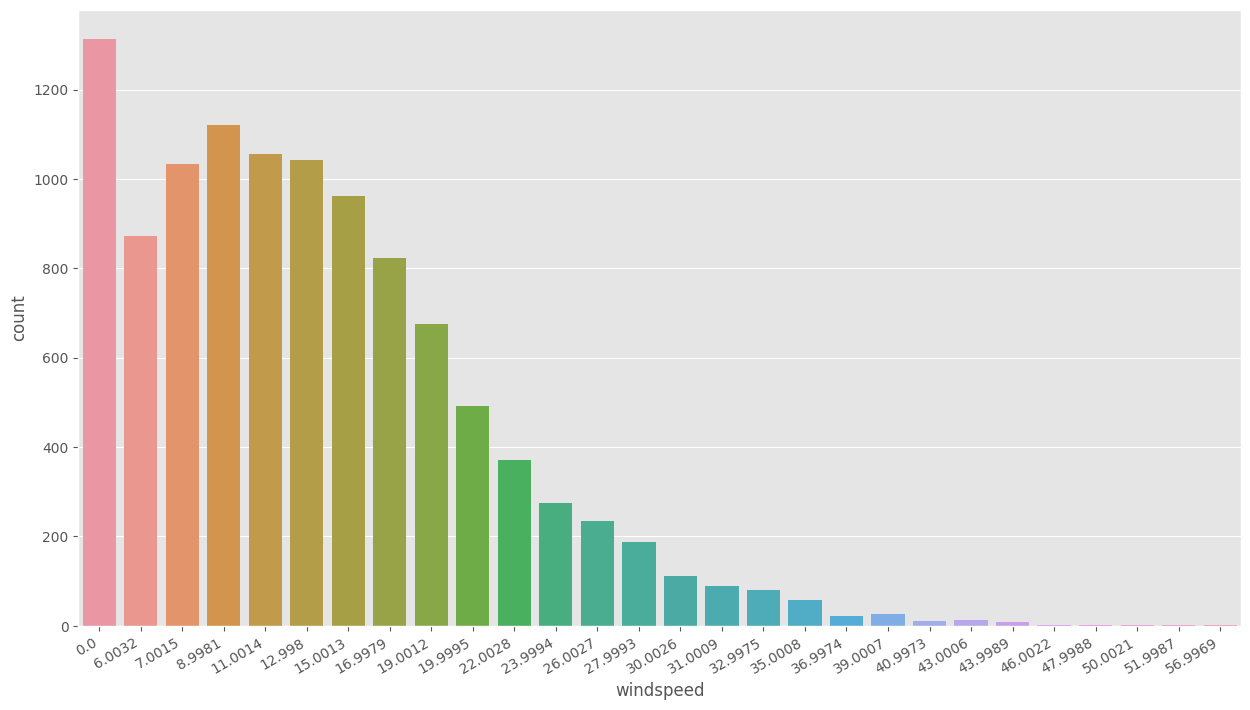

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=30, ha='right')
sns.countplot(data=pre_train, x='windspeed')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(p_train, p_test):
    print(f'before: {p_train.shape} / {p_test.shape}')

    train_wind0 = p_train.loc[p_train['windspeed'] == 0]
    train_wind_not0 = p_train.loc[p_train['windspeed'] != 0]
    test_wind0 = p_test.loc[p_test['windspeed'] == 0]
    test_wind_not0 = p_test.loc[p_test['windspeed'] != 0]

    wind_cols = list(abs(p_train.corr())['windspeed'].sort_values().index)
    wind_cols.remove('count')
    wind_cols.remove('windspeed')
    print(f'len(wind_cols): {len(wind_cols)}')

    # training
    wind_rfc = RandomForestClassifier(random_state=args.SEED)
    train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')
    wind_rfc.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    score = wind_rfc.score(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    print(f'score: {score}')

    # predict
    train_wind0['windspeed'] = wind_rfc.predict(train_wind0[wind_cols])
    test_wind0['windspeed'] = wind_rfc.predict(test_wind0[wind_cols])

    # concat
    train = train_wind_not0.append(train_wind0).sort_values(by=['datetime'])
    train['windspeed'] = train['windspeed'].astype('float')
    train.reset_index(drop=True, inplace=True)
    test = test_wind_not0.append(test_wind0).sort_values(by=['datetime'])
    test['windspeed'] = test['windspeed'].astype('float')
    test.reset_index(drop=True, inplace=True)

    print(f'after: {train.shape} / {test.shape}')
    return train, test

In [ ]:
pre_train, pre_test = predict_windspeed(pre_train, pre_test)

before: (10886, 12) / (6493, 11)
len(wind_cols): 9
score: 1.0
after: (10886, 12) / (6493, 11)


<Axes: xlabel='windspeed', ylabel='count'>

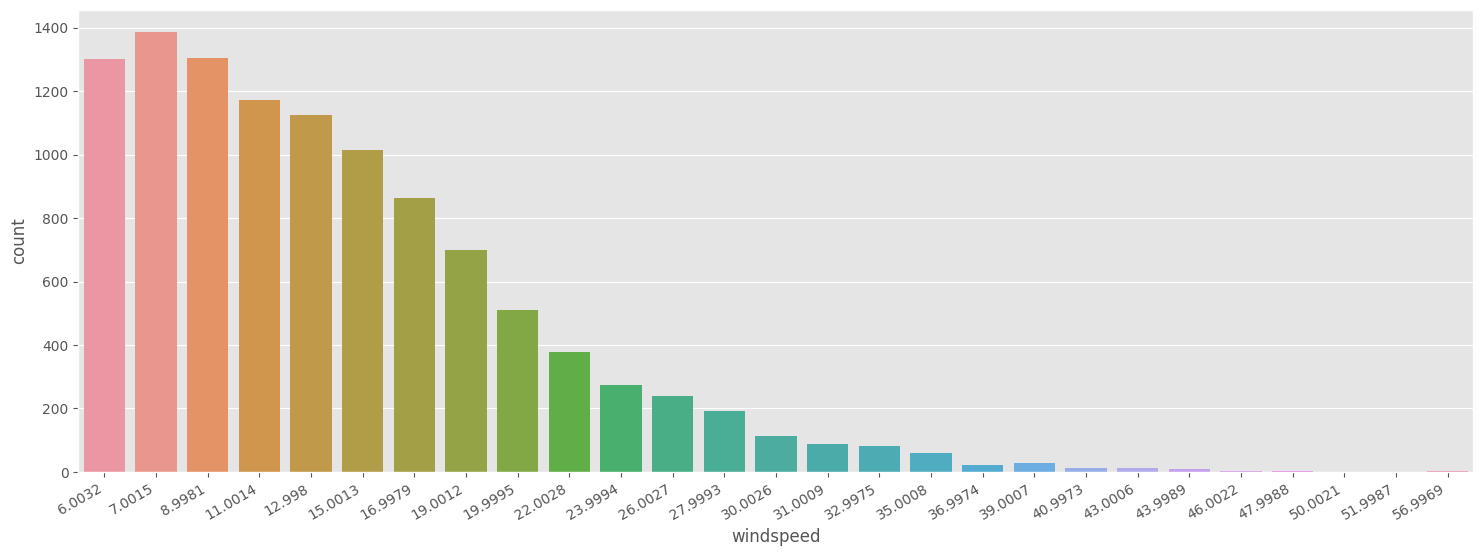

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax)
plt.xticks(rotation=30, ha='right')
sns.countplot(data=pre_train, x='windspeed', ax=ax)

# Feature Selection

In [ ]:
pre_train.describe()

,holiday,weather,humidity,windspeed,count,year,day,hour,pca_temp,pca_month,pca_workingday
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04
mean,0.028569,1.418427,61.886460,13.874775,191.574132,2011.501929,9.992559,11.541613,-3.341888e-16,-6.683775e-16,-2.167005e-16
std,0.166599,0.633839,19.245033,7.033159,181.144454,0.500019,5.476608,6.915838,1.146898e+01,3.773440e+00,2.065391e+00
min,0.000000,1.000000,0.000000,6.003200,1.000000,2011.000000,1.000000,0.000000,-2.899539e+01,-5.862735e+00,-3.027260e+00
25%,0.000000,1.000000,47.000000,8.998100,42.000000,2011.000000,5.000000,6.000000,-8.963992e+00,-4.038656e+00,-2.057873e+00
50%,0.000000,1.000000,62.000000,12.998000,145.000000,2012.000000,10.000000,12.000000,-6.128708e-01,-7.225650e-01,-1.190992e-01
75%,0.000000,2.000000,77.000000,16.997900,284.000000,2012.000000,15.000000,18.000000,9.403582e+00,2.593526e+00,2.166629e+00
max,1.000000,4.000000,100.000000,56.996900,977.000000,2012.000000,19.000000,23.000000,2.999261e+01,5.909617e+00,3.136016e+00


## drop cols

In [ ]:
print(pre_train['day'].unique())
print(pre_test['day'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29 30 31]


In [ ]:
drop_cols = ['datetime', 'day']

print(f'before: {pre_train.shape} / {pre_test.shape}')
pre_train = pre_train.drop(drop_cols, axis=1)
pre_test = pre_test.drop(drop_cols, axis=1)
print(f'after: {pre_train.shape} / {pre_test.shape}')

before: (10886, 12) / (6493, 11)
after: (10886, 10) / (6493, 9)


## convert categorical

In [ ]:
categorical_cols = [
    'holiday', 'weather', 'year', 'hour'
]

for col in categorical_cols:
    pre_train[col] = pre_train[col].astype('category')
    pre_test[col] = pre_test[col].astype('category')

pre_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   holiday         10886 non-null  category
 1   weather         10886 non-null  category
 2   humidity        10886 non-null  int64   
 3   windspeed       10886 non-null  float64 
 4   count           10886 non-null  int64   
 5   year            10886 non-null  category
 6   hour            10886 non-null  category
 7   pca_temp        10886 non-null  float64 
 8   pca_month       10886 non-null  float64 
 9   pca_workingday  10886 non-null  float64 
dtypes: category(4), float64(4), int64(2)
memory usage: 554.1 KB


In [ ]:
pre_train.shape, pre_test.shape

((10886, 10), (6493, 9))

# Base Model

In [ ]:
print(f'{pre_train.shape} / {pre_test.shape}')

(10886, 10) / (6493, 9)


In [ ]:
train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

((10886, 10), (6493, 9))

## split data

In [ ]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
base_model = RandomForestRegressor(random_state=args.SEED)
base_model

RandomForestRegressor(random_state=42)

In [ ]:
base_model.fit(x_tr, y_tr)

RandomForestRegressor(random_state=42)

In [ ]:
tr_score = base_model.score(x_tr, y_tr)
te_score = base_model.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.992298236232342 / 0.952124649444184


### prediction

In [ ]:
pre_tr = base_model.predict(x_tr)
pre_te = base_model.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.15887840584950114 / 0.3272022572344777


<Axes: ylabel='Density'>

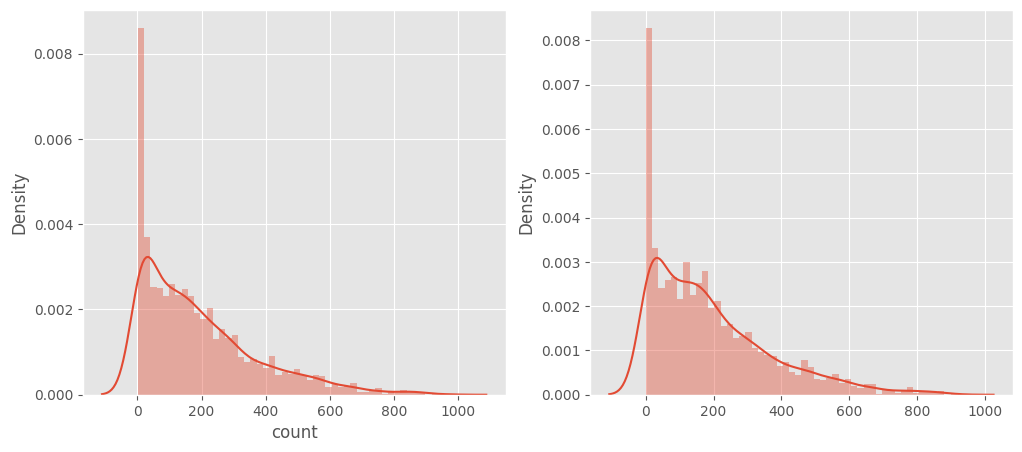

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pre_te, ax=ax2, bins=50)

Text(0, 0.5, 'prediction(pre_te)')

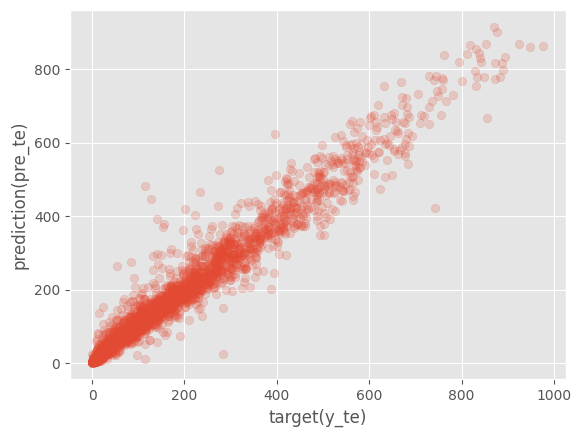

In [ ]:
plt.scatter(y_te, pre_te, alpha=0.2)
plt.xlabel('target(y_te)')
plt.ylabel('prediction(pre_te)')

### create result

In [ ]:
base_result = {
    'model':'base_model',
    'tr_score':tr_score,
    'te_score':te_score,
    'tr_rmsle':tr_rmsle,
    'te_rmsle':te_rmsle,
    'scaling':'None'
}

base_result

{'model': 'base_model',
 'tr_score': 0.992298236232342,
 'te_score': 0.952124649444184,
 'tr_rmsle': 0.15887840584950114,
 'te_rmsle': 0.3272022572344777,
 'scaling': 'None'}

# ModelV1

In [ ]:
print(f'{pre_train.shape} / {pre_test.shape}')

(10886, 10) / (6493, 9)


In [ ]:
train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

((10886, 10), (6493, 9))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   holiday         10886 non-null  category
 1   weather         10886 non-null  category
 2   humidity        10886 non-null  int64   
 3   windspeed       10886 non-null  float64 
 4   count           10886 non-null  int64   
 5   year            10886 non-null  category
 6   hour            10886 non-null  category
 7   pca_temp        10886 non-null  float64 
 8   pca_month       10886 non-null  float64 
 9   pca_workingday  10886 non-null  float64 
dtypes: category(4), float64(4), int64(2)
memory usage: 554.1 KB


In [ ]:
train.head(3)

,holiday,weather,humidity,windspeed,count,year,hour,pca_temp,pca_month,pca_workingday
0,0,1,81,7.0015,16,2011,0,13.848653,5.909617,2.166629
1,0,1,80,6.0032,40,2011,1,14.963061,5.909617,2.166629
2,0,1,80,6.0032,32,2011,2,14.963061,5.909617,2.166629


## Scaling

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
print(f'before: {train.shape} / {test.shape}')

scaling_cols = ['humidity', 'windspeed', 'pca_temp', 'pca_month', 'pca_workingday']

train_scaling = train[scaling_cols]
test_scaling = test[scaling_cols]

scaler1 = PowerTransformer()
scaler1.fit(train_scaling)

train_scaled = scaler1.transform(train_scaling)
train[scaling_cols] = train_scaled
test_scaled = scaler1.transform(test_scaling)
test[scaling_cols] = test_scaled

print(f'after: {train.shape} / {test.shape}')

before: (10886, 10) / (6493, 9)
after: (10886, 10) / (6493, 9)


In [ ]:
train.head(3)

,holiday,weather,humidity,windspeed,count,year,hour,pca_temp,pca_month,pca_workingday
0,0,1,0.993161,-1.176302,16,2011,0,1.197992,1.563526,1.044808
1,0,1,0.941223,-1.518772,40,2011,1,1.291643,1.563526,1.044808
2,0,1,0.941223,-1.518772,32,2011,2,1.291643,1.563526,1.044808


## split data

In [ ]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelv1 = RandomForestRegressor(random_state=args.SEED)
modelv1

RandomForestRegressor(random_state=42)

In [ ]:
modelv1.fit(x_tr, y_tr)

RandomForestRegressor(random_state=42)

In [ ]:
tr_score = modelv1.score(x_tr, y_tr)
te_score = modelv1.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.9922884852142911 / 0.9519436783559803


### prediction

In [ ]:
pre_tr = modelv1.predict(x_tr)
pre_te = modelv1.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.15859851346825202 / 0.32775154434987513


<Axes: ylabel='Density'>

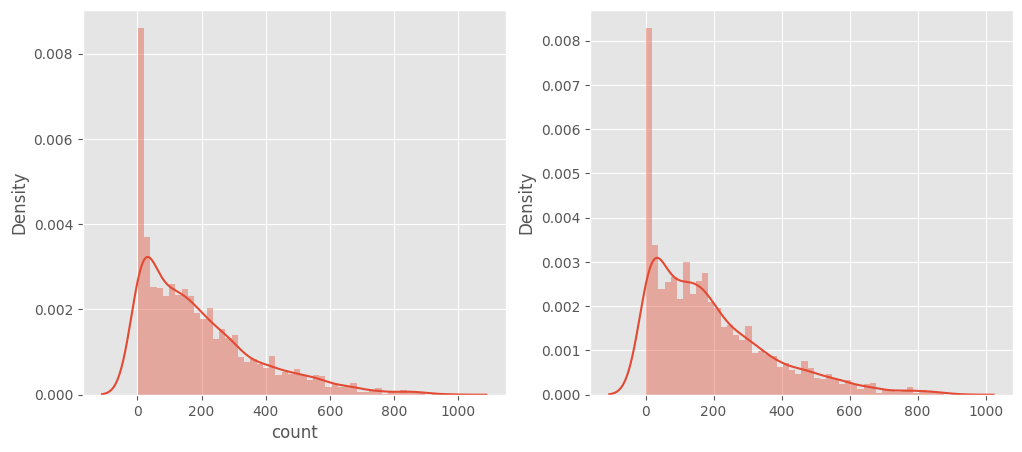

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pre_te, ax=ax2, bins=50)

### create result

In [ ]:
modelv1_result = {
    'model':'modelv1',
    'tr_score':tr_score,
    'te_score':te_score,
    'tr_rmsle':tr_rmsle,
    'te_rmsle':te_rmsle,
    'scaling':'PowerTransformer'
}

modelv1_result

{'model': 'modelv1',
 'tr_score': 0.9922884852142911,
 'te_score': 0.9519436783559803,
 'tr_rmsle': 0.15859851346825202,
 'te_rmsle': 0.32775154434987513,
 'scaling': 'PowerTransformer'}

In [ ]:
base_result

{'model': 'base_model',
 'tr_score': 0.992298236232342,
 'te_score': 0.952124649444184,
 'tr_rmsle': 0.15887840584950114,
 'te_rmsle': 0.3272022572344777,
 'scaling': 'None'}

# ModelV2

In [ ]:
print(f'{pre_train.shape} / {pre_test.shape}')

(10886, 10) / (6493, 9)


In [ ]:
train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

((10886, 10), (6493, 9))

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
print(f'before: {train.shape} / {test.shape}')

scaling_cols = ['humidity', 'windspeed', 'pca_temp', 'pca_month', 'pca_workingday']

train_scaling = train[scaling_cols]
test_scaling = test[scaling_cols]

scaler2 = StandardScaler()
scaler2.fit(train_scaling)

train_scaled = scaler2.transform(train_scaling)
train[scaling_cols] = train_scaled
test_scaled = scaler2.transform(test_scaling)
test[scaling_cols] = test_scaled

print(f'after: {train.shape} / {test.shape}')

before: (10886, 10) / (6493, 9)
after: (10886, 10) / (6493, 9)


In [ ]:
train.head(3)

,holiday,weather,humidity,windspeed,count,year,hour,pca_temp,pca_month,pca_workingday
0,0,1,0.993213,-0.977312,16,2011,0,1.207544,1.566181,1.049065
1,0,1,0.941249,-1.119260,40,2011,1,1.304715,1.566181,1.049065
2,0,1,0.941249,-1.119260,32,2011,2,1.304715,1.566181,1.049065


## split data

In [ ]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelv2 = RandomForestRegressor(random_state=args.SEED)
modelv2

RandomForestRegressor(random_state=42)

In [ ]:
modelv2.fit(x_tr, y_tr)

RandomForestRegressor(random_state=42)

In [ ]:
tr_score = modelv2.score(x_tr, y_tr)
te_score = modelv2.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.9922902825993216 / 0.9520186143346205


### prediction

In [ ]:
pre_tr = modelv2.predict(x_tr)
pre_te = modelv2.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.1587318342499159 / 0.3270010643617227


<Axes: ylabel='Density'>

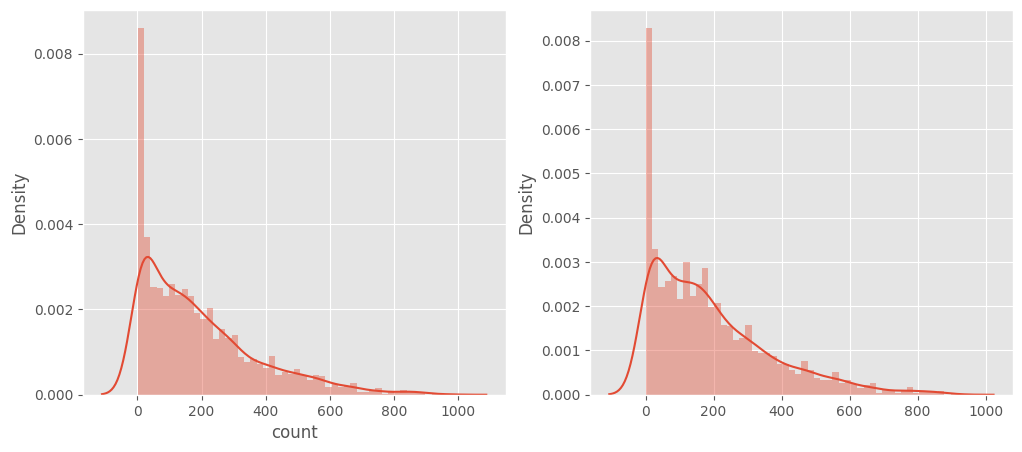

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pre_te, ax=ax2, bins=50)

### create result

In [ ]:
modelv2_result = {
    'model':'modelv2',
    'tr_score':tr_score,
    'te_score':te_score,
    'tr_rmsle':tr_rmsle,
    'te_rmsle':te_rmsle,
    'scaling':'StandardScaler'
}

modelv2_result

{'model': 'modelv2',
 'tr_score': 0.9922902825993216,
 'te_score': 0.9520186143346205,
 'tr_rmsle': 0.1587318342499159,
 'te_rmsle': 0.3270010643617227,
 'scaling': 'StandardScaler'}

In [ ]:
base_result

{'model': 'base_model',
 'tr_score': 0.992298236232342,
 'te_score': 0.952124649444184,
 'tr_rmsle': 0.15887840584950114,
 'te_rmsle': 0.3272022572344777,
 'scaling': 'None'}

# ModelV3

In [ ]:
print(f'{pre_train.shape} / {pre_test.shape}')

(10886, 10) / (6493, 9)


In [ ]:
train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

((10886, 10), (6493, 9))

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(f'before: {train.shape} / {test.shape}')

scaling_cols = ['humidity', 'windspeed', 'pca_temp', 'pca_month', 'pca_workingday']

train_scaling = train[scaling_cols]
test_scaling = test[scaling_cols]

scaler3 = MinMaxScaler()
scaler3.fit(train_scaling)

train_scaled = scaler3.transform(train_scaling)
train[scaling_cols] = train_scaled
test_scaled = scaler3.transform(test_scaling)
test[scaling_cols] = test_scaled

print(f'after: {train.shape} / {test.shape}')

before: (10886, 10) / (6493, 9)
after: (10886, 10) / (6493, 9)


In [ ]:
train.head(3)

,holiday,weather,humidity,windspeed,count,year,hour,pca_temp,pca_month,pca_workingday
0,0,1,0.81,0.019577,16,2011,0,0.726318,1.0,0.842716
1,0,1,0.80,0.000000,40,2011,1,0.745210,1.0,0.842716
2,0,1,0.80,0.000000,32,2011,2,0.745210,1.0,0.842716


## split data

In [ ]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelv3 = RandomForestRegressor(random_state=args.SEED)
modelv3

RandomForestRegressor(random_state=42)

In [ ]:
modelv3.fit(x_tr, y_tr)

RandomForestRegressor(random_state=42)

In [ ]:
tr_score = modelv3.score(x_tr, y_tr)
te_score = modelv3.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.9922929710082579 / 0.9519478306527248


### prediction

In [ ]:
pre_tr = modelv3.predict(x_tr)
pre_te = modelv3.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.15881517179156956 / 0.3271147351737582


<Axes: ylabel='Density'>

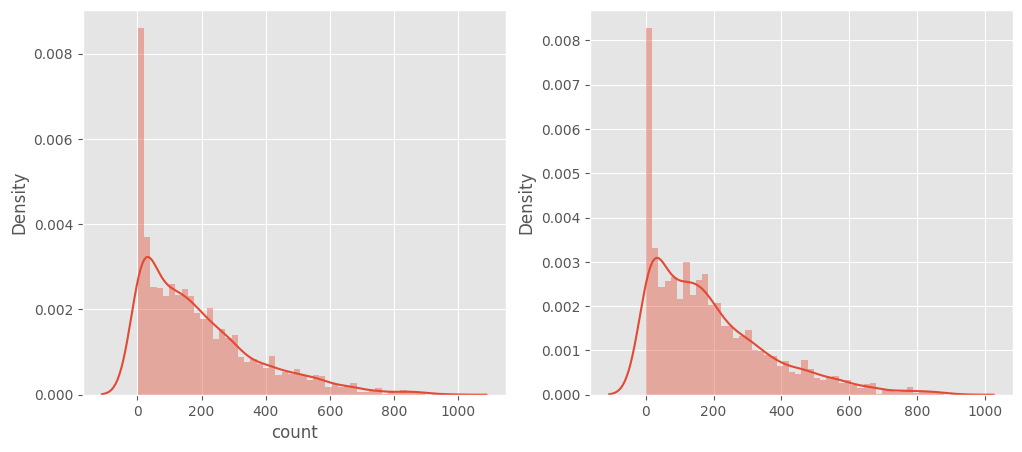

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pre_te, ax=ax2, bins=50)

### create result

In [ ]:
modelv3_result = {
    'model':'modelv3',
    'tr_score':tr_score,
    'te_score':te_score,
    'tr_rmsle':tr_rmsle,
    'te_rmsle':te_rmsle,
    'scaling':'MinMaxScaler'
}

modelv3_result

{'model': 'modelv3',
 'tr_score': 0.9922929710082579,
 'te_score': 0.9519478306527248,
 'tr_rmsle': 0.15881517179156956,
 'te_rmsle': 0.3271147351737582,
 'scaling': 'MinMaxScaler'}

In [ ]:
base_result

{'model': 'base_model',
 'tr_score': 0.992298236232342,
 'te_score': 0.952124649444184,
 'tr_rmsle': 0.15887840584950114,
 'te_rmsle': 0.3272022572344777,
 'scaling': 'None'}

# ModelV4

In [ ]:
print(f'{pre_train.shape} / {pre_test.shape}')

(10886, 10) / (6493, 9)


In [ ]:
train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

((10886, 10), (6493, 9))

## Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
print(f'before: {train.shape} / {test.shape}')

scaling_cols = ['humidity', 'windspeed', 'pca_temp', 'pca_month', 'pca_workingday']

train_scaling = train[scaling_cols]
test_scaling = test[scaling_cols]

scaler4 = RobustScaler()
scaler4.fit(train_scaling)

train_scaled = scaler4.transform(train_scaling)
train[scaling_cols] = train_scaled
test_scaled = scaler4.transform(test_scaling)
test[scaling_cols] = test_scaled

print(f'after: {train.shape} / {test.shape}')

before: (10886, 10) / (6493, 9)
after: (10886, 10) / (6493, 9)


In [ ]:
train.head(3)

,holiday,weather,humidity,windspeed,count,year,hour,pca_temp,pca_month,pca_workingday
0,0,1,0.633333,-0.749581,16,2011,0,0.787340,1.0,0.541064
1,0,1,0.600000,-0.874372,40,2011,1,0.848012,1.0,0.541064
2,0,1,0.600000,-0.874372,32,2011,2,0.848012,1.0,0.541064


## split data

In [ ]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelv4 = RandomForestRegressor(random_state=args.SEED)
modelv4

RandomForestRegressor(random_state=42)

In [ ]:
modelv4.fit(x_tr, y_tr)

RandomForestRegressor(random_state=42)

In [ ]:
tr_score = modelv4.score(x_tr, y_tr)
te_score = modelv4.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.9922855326461109 / 0.9518634389103557


### prediction

In [ ]:
pre_tr = modelv4.predict(x_tr)
pre_te = modelv4.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.15869854052229204 / 0.32768552204568446


<Axes: ylabel='Density'>

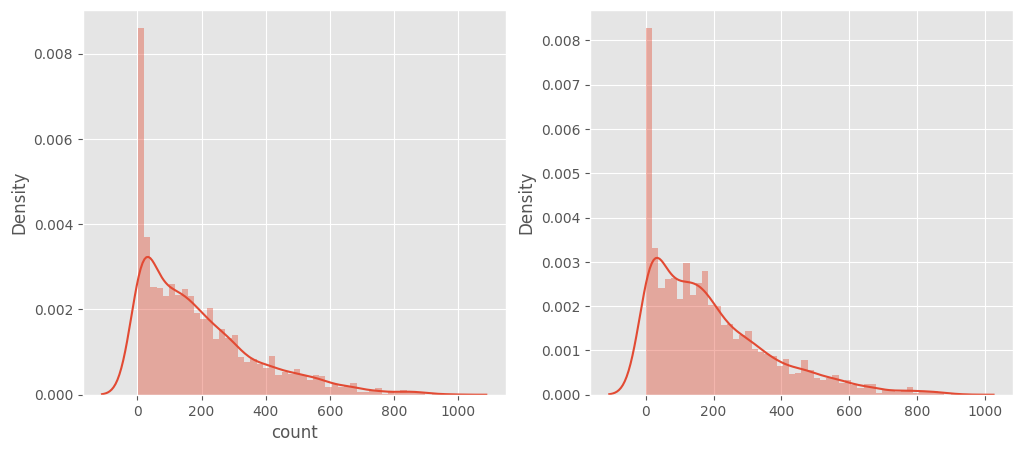

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pre_te, ax=ax2, bins=50)

### create result

In [ ]:
modelv4_result = {
    'model':'modelv4',
    'tr_score':tr_score,
    'te_score':te_score,
    'tr_rmsle':tr_rmsle,
    'te_rmsle':te_rmsle,
    'scaling':'RobustScaler'
}

modelv4_result

{'model': 'modelv4',
 'tr_score': 0.9922855326461109,
 'te_score': 0.9518634389103557,
 'tr_rmsle': 0.15869854052229204,
 'te_rmsle': 0.32768552204568446,
 'scaling': 'RobustScaler'}

In [ ]:
base_result

{'model': 'base_model',
 'tr_score': 0.992298236232342,
 'te_score': 0.952124649444184,
 'tr_rmsle': 0.15887840584950114,
 'te_rmsle': 0.3272022572344777,
 'scaling': 'None'}

# 결과 비교

In [ ]:
df_result = pd.DataFrame([base_result, modelv1_result, modelv2_result, modelv3_result, modelv4_result])

df_result.sort_values(by=['te_rmsle', 'tr_rmsle'])

,model,tr_score,te_score,tr_rmsle,te_rmsle,scaling
2,modelv2,0.992290,0.952019,0.158732,0.327001,StandardScaler
3,modelv3,0.992293,0.951948,0.158815,0.327115,MinMaxScaler
0,base_model,0.992298,0.952125,0.158878,0.327202,None
4,modelv4,0.992286,0.951863,0.158699,0.327686,RobustScaler
1,modelv1,0.992288,0.951944,0.158599,0.327752,PowerTransformer


# Submit

In [ ]:
test = pre_test.copy()

test.shape

(6493, 9)

In [ ]:
test_scaling = test[scaling_cols]

test_scaled = scaler2.transform(test_scaling)
test[scaling_cols] = test_scaled

In [ ]:
test_predict = modelv2.predict(test)

test_predict.shape

(6493,)

In [ ]:
submission = pd.read_csv(args.submission_path)

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


In [ ]:
submission['count'] = test_predict

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,13.14
1,2011-01-20 01:00:00,4.93
2,2011-01-20 02:00:00,3.37


In [ ]:
args.submission_file
submission_score = modelv2_result['te_rmsle']
submission.to_csv(args.submission_file.format(submission_score), index=False)

base model보다 score가 나쁘다.

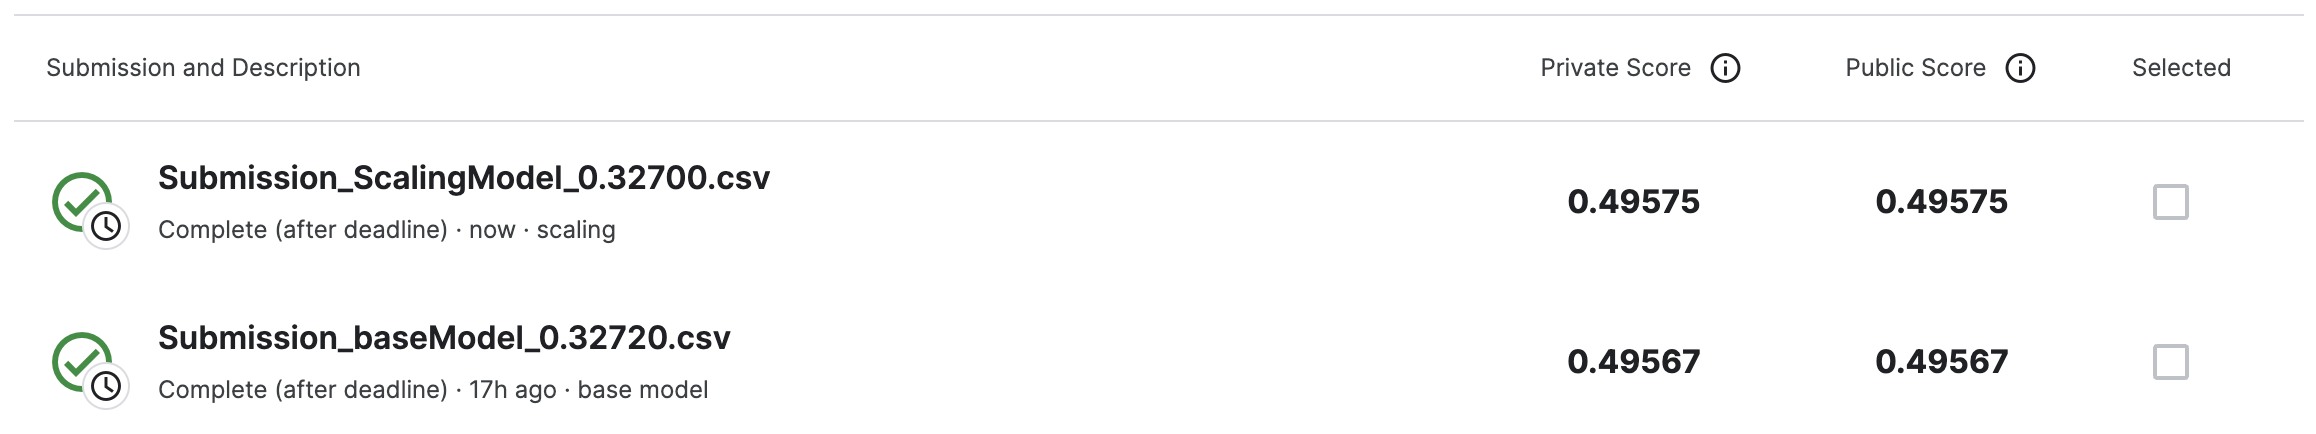